# AI Practical Assignment: Implement NGRAM Algorithm and show its complexity and performance

Submitted by: Sanskar Sharma.

PRN: 0120180381.

Seat number: T204058.

Roll number: 090.

Division: AI1. Batch: MA2

In [50]:
#!/bin/env python

import nltk
import argparse
from itertools import product
import math
from pathlib import Path

#Start of sentence
SOS = "<s> "

#End of sentence 
EOS = "</s>"

#Unique word/occurs only once
UNK = "<UNK>"

def add_sentence_tokens(sentences, n):
    """Wrap each sentence in SOS and EOS tokens.

    For n >= 2, n-1 SOS tokens are added, otherwise only one is added.

    Args:
        sentences (list of str): the sentences to wrap.
        n (int): order of the n-gram model which will use these sentences.
    Returns:
        List of sentences with SOS and EOS tokens wrapped around them.

    """
    sos = SOS * (n-1) if n > 1 else SOS
    return ['{}{} {}'.format(sos, s, EOS) for s in sentences]

def replace_singletons(tokens):
    """Replace tokens which appear only once in the corpus with <UNK>.
    
    Args:
        tokens (list of str): the tokens comprising the corpus.
    Returns:
        The same list of tokens with each singleton replaced by <UNK>.
    
    """
    vocab = nltk.FreqDist(tokens)
    return [token if vocab[token] > 1 else UNK for token in tokens]

def preprocess(sentences, n):
    """Add SOS/EOS/UNK tokens to given sentences and tokenize.

    Args:
        sentences (list of str): the sentences to preprocess.
        n (int): order of the n-gram model which will use these sentences.
    Returns:
        The preprocessed sentences, tokenized by words.

    """
    sentences = add_sentence_tokens(sentences, n)
    tokens = ' '.join(sentences).split(' ')
    tokens = replace_singletons(tokens)
    return tokens


#Loading the dataset to implement ngram model
def load_data(data_dir):
    """Load train and test corpora from a directory.

    Directory must contain two files: train.txt and test.txt.
    Newlines will be stripped out. 

    Args:
        data_dir (Path) -- pathlib.Path of the directory to use. 

    Returns:
        The train and test sets, as lists of sentences.

    """
    train_path = data_dir.joinpath('train.txt').absolute().as_posix()
    test_path  = data_dir.joinpath('test.txt').absolute().as_posix()

    with open(train_path, 'r') as f:
        train = [l.strip() for l in f.readlines()]
    with open(test_path, 'r') as f:
        test = [l.strip() for l in f.readlines()]
    return train, test


class LanguageModel(object):
    """An n-gram language model trained on a given corpus.
    
    For a given n and given training corpus, constructs an n-gram language
    model for the corpus by:
    1. preprocessing the corpus (adding SOS/EOS/UNK tokens)
    2. calculating (smoothed) probabilities for each n-gram

    Also contains methods for calculating the perplexity of the model
    against another corpus, and for generating sentences.

    Args:
        train_data (list of str): list of sentences comprising the training corpus.
        n (int): the order of language model to build (i.e. 1 for unigram, 2 for bigram, etc.).
        laplace (int): lambda multiplier to use for laplace smoothing (default 1 for add-1 smoothing).

    """

    def __init__(self, train_data, n, laplace=1):
        self.n = n
        self.laplace = laplace
        self.tokens = preprocess(train_data, n)
        self.vocab  = nltk.FreqDist(self.tokens)
        self.model  = self._create_model()
        self.masks  = list(reversed(list(product((0,1), repeat=n))))

    def _smooth(self):
        """Apply Laplace smoothing to n-gram frequency distribution.
        
        Here, n_grams refers to the n-grams of the tokens in the training corpus,
        while m_grams refers to the first (n-1) tokens of each n-gram.

        Returns:
            dict: Mapping of each n-gram (tuple of str) to its Laplace-smoothed 
            probability (float).

        """
        vocab_size = len(self.vocab)

        n_grams = nltk.ngrams(self.tokens, self.n)
        n_vocab = nltk.FreqDist(n_grams)

        m_grams = nltk.ngrams(self.tokens, self.n-1)
        m_vocab = nltk.FreqDist(m_grams)

        def smoothed_count(n_gram, n_count):
            m_gram = n_gram[:-1]
            m_count = m_vocab[m_gram]
            return (n_count + self.laplace) / (m_count + self.laplace * vocab_size)

        return { n_gram: smoothed_count(n_gram, count) for n_gram, count in n_vocab.items() }

    def _create_model(self):
        """Create a probability distribution for the vocabulary of the training corpus.
        
        If building a unigram model, the probabilities are simple relative frequencies
        of each token with the entire corpus.

        Otherwise, the probabilities are Laplace-smoothed relative frequencies.

        Returns:
            A dict mapping each n-gram (tuple of str) to its probability (float).

        """
        if self.n == 1:
            num_tokens = len(self.tokens)
            return { (unigram,): count / num_tokens for unigram, count in self.vocab.items() }
        else:
            return self._smooth()

    def _convert_oov(self, ngram):
        """Convert, if necessary, a given n-gram to one which is known by the model.

        Starting with the unmodified ngram, check each possible permutation of the n-gram
        with each index of the n-gram containing either the original token or <UNK>. Stop
        when the model contains an entry for that permutation.

        This is achieved by creating a 'bitmask' for the n-gram tuple, and swapping out
        each flagged token for <UNK>. Thus, in the worst case, this function checks 2^n
        possible n-grams before returning.

        Returns:
            The n-gram with <UNK> tokens in certain positions such that the model
            contains an entry for it.

        """
        mask = lambda ngram, bitmask: tuple((token if flag == 1 else "<UNK>" for token,flag in zip(ngram, bitmask)))

        ngram = (ngram,) if type(ngram) is str else ngram
        for possible_known in [mask(ngram, bitmask) for bitmask in self.masks]:
            if possible_known in self.model:
                return possible_known

    def perplexity(self, test_data):
        """Calculate the perplexity of the model against a given test corpus.
        
        Args:
            test_data (list of str): sentences comprising the training corpus.
        Returns:
            The perplexity of the model as a float.
        
        """
        test_tokens = preprocess(test_data, self.n)
        test_ngrams = nltk.ngrams(test_tokens, self.n)
        N = len(test_tokens)

        known_ngrams  = (self._convert_oov(ngram) for ngram in test_ngrams)
        probabilities = [self.model[ngram] for ngram in known_ngrams]

        return math.exp((-1/N) * sum(map(math.log, probabilities)))

    def _best_candidate(self, prev, i, without=[]):
        """Choose the most likely next token given the previous (n-1) tokens.

        If selecting the first word of the sentence (after the SOS tokens),
        the i'th best candidate will be selected, to create variety.
        If no candidates are found, the EOS token is returned with probability 1.

        Args:
            prev (tuple of str): the previous n-1 tokens of the sentence.
            i (int): which candidate to select if not the most probable one.
            without (list of str): tokens to exclude from the candidates list.
        Returns:
            A tuple with the next most probable token and its corresponding probability.

        """
        blacklist  = ["<UNK>"] + without
        candidates = ((ngram[-1],prob) for ngram,prob in self.model.items() if ngram[:-1]==prev)
        candidates = filter(lambda candidate: candidate[0] not in blacklist, candidates)
        candidates = sorted(candidates, key=lambda candidate: candidate[1], reverse=True)
        if len(candidates) == 0:
            return ("</s>", 1)
        else:
            return candidates[0 if prev != () and prev[-1] != "<s>" else i]
     
    def generate_sentences(self, num, min_len=12, max_len=24):
        """Generate num random sentences using the language model.

        Sentences always begin with the SOS token and end with the EOS token.
        While unigram model sentences will only exclude the UNK token, n>1 models
        will also exclude all other words already in the sentence.

        Args:
            num (int): the number of sentences to generate.
            min_len (int): minimum allowed sentence length.
            max_len (int): maximum allowed sentence length.
        Yields:
            A tuple with the generated sentence and the combined probability
            (in log-space) of all of its n-grams.

        """
        for i in range(num):
            sent, prob = ["<s>"] * max(1, self.n-1), 1
            while sent[-1] != "</s>":
                prev = () if self.n == 1 else tuple(sent[-(self.n-1):])
                blacklist = sent + (["</s>"] if len(sent) < min_len else [])
                next_token, next_prob = self._best_candidate(prev, i, without=blacklist)
                sent.append(next_token)
                prob *= next_prob
                
                if len(sent) >= max_len:
                    sent.append("</s>")

            yield ' '.join(sent), -1/math.log(prob)
       

def temporary_function(i):
    """This function helps to run language model for different N-grams
    
    """
    
    parser = argparse.ArgumentParser("N-gram Language Model")
    parser.add_argument('--data', type=str, required=True,
        help='Location of the data directory containing train.txt and test.txt')
    parser.add_argument('--n', type=int, required=True,
        help='Order of N-gram model to create (i.e. 1 for unigram, 2 for bigram, etc.)')
    parser.add_argument('--laplace', type=float, default=0.01,
        help='Lambda parameter for Laplace smoothing (default is 0.01 -- use 1 for add-1 smoothing)')
    parser.add_argument('--num', type=int, default=10,
        help='Number of sentences to generate (default 10)')
    args = parser.parse_args(['--data','data','--n',i])

    # Load and prepare train/test data
    data_path = Path(args.data)
    train, test = load_data(data_path)

    print("Loading {}-gram model...".format(args.n))
    lm = LanguageModel(train, args.n, laplace=args.laplace)
    print("Vocabulary size: {}".format(len(lm.vocab)))

    print("Generating sentences...")
    for sentence, prob in lm.generate_sentences(args.num):
        print("{} ({:.5f})".format(sentence, prob))

    perplexity = lm.perplexity(test)
    print("Model perplexity: {:.3f}".format(perplexity))
    print("")
    
    return perplexity

#Main function
if __name__ == '__main__':
    print("\tAI Practical Exam: N-gram Algorithm and it's complexity and performance.")
    print("\t\t\t\tBy Sanskar Sharma")
    print("\t\t\t\tPRN: 0120180381")
    print("\t\t\t\tSeat no: T204058")
    ngram_and_perplexity={}
    while(1):

        i=input("Enter the order of N-gram (Enter -1 to exit):")
        if int(i)==-1:
            break
        ngram_and_perplexity[i]=temporary_function(i)
        #%timeit temporary_function(i)

	AI Practical Exam: N-gram Algorithm and it's complexity and performance.
				By Sanskar Sharma
				PRN: 0120180381
				Seat no: T204058
Enter the order of N-gram (Enter -1 to exit):1
Loading 1-gram model...
Vocabulary size: 23505
Generating sentences...
<s> the of to in and said a mln for dlrs vs </s> (0.02054)
<s> of to in and said a mln for dlrs vs it </s> (0.01978)
<s> to in and said a mln for dlrs vs it pct of on is from its that at by be cts year will </s> (0.00904)
<s> in and said a mln for dlrs vs it pct on to is from its that at by be cts year will with </s> (0.00890)
<s> and said a mln for dlrs vs it pct on is in from its that at by be cts year will with billion </s> (0.00876)
<s> said a mln for dlrs vs it pct on is from and its that at by be cts year will with billion net </s> (0.00864)
<s> a mln for dlrs vs it pct on is from its said that at by be cts year will with billion net was </s> (0.00853)
<s> mln for dlrs vs it pct on is from its that a at by be cts year will with b

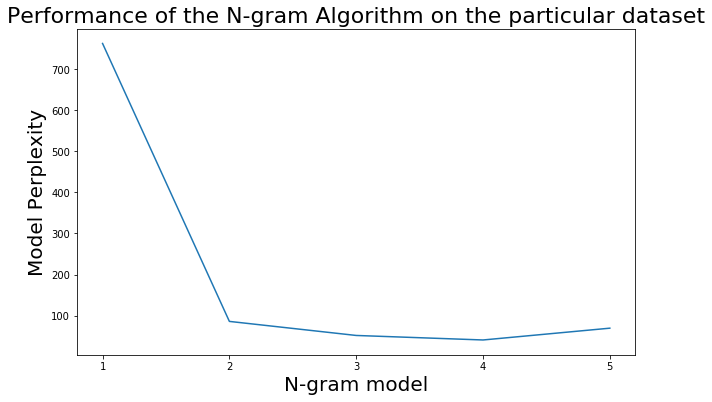

In [51]:
#Performance of the model on basis of their recorded perplexities!
import matplotlib.pyplot as plt

lists = sorted(ngram_and_perplexity.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=[10,6])
plt.plot(x, y)
plt.xlabel("N-gram model",fontsize=20)
plt.ylabel("Model Perplexity",fontsize=20)
plt.title("Performance of the N-gram Algorithm on the particular dataset",fontsize=22)
plt.show()
#4-gram model is the best suited for the following test data.

In [52]:
#total number of words in the test.txt dataset
file = open("data/test.txt", "rt")
data = file.read()
words = data.split()

print('Number of words in test text file :', len(words))

Number of words in test text file : 335409


In [53]:
#total number of words in the train.txt dataset
file = open("data/train.txt", "rt")
data = file.read()
words = data.split()

print('Number of words in train text file :', len(words))

Number of words in train text file : 1347777


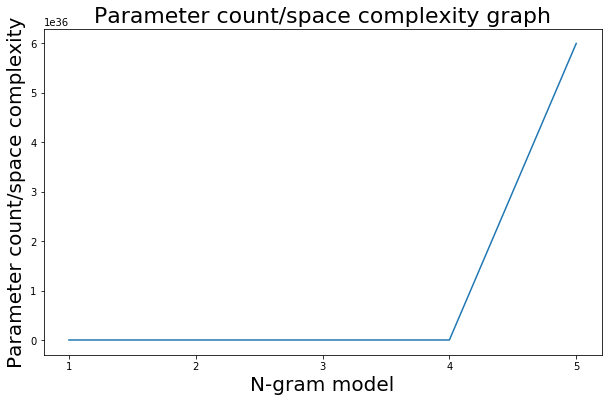

In [54]:
#Parameter/space complexity for different models is as follows:
#Import math Library
import math
ngram_and_p_complexity={}
#Since the number of word is too large hence we get a flat line
l=len(words)
for i in ngram_and_perplexity.keys():
    
    ngram_and_p_complexity[i]=math.pow(l,int(i))*(l-1)
    
lists = sorted(ngram_and_p_complexity.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=[10,6])
plt.plot(x, y)
plt.xlabel("N-gram model",fontsize=20)
plt.ylabel("Parameter count/space complexity",fontsize=20)
plt.title("Parameter count/space complexity graph",fontsize=22)
plt.show()

#1-gram model is best in this
#Observation: since number of words are too large hene the parameter count is not countable
#Or can say not distinguishable till 4-gram.

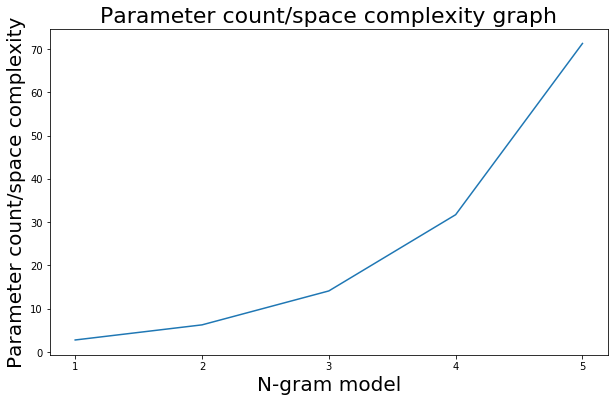

In [55]:
ngram_and_p_complexity={}
#Since the number of word is too large hence we get a flat line
#Reduce the word count and get an observable graph for the same
l=len(words)/600000
for i in ngram_and_perplexity.keys():
    
    ngram_and_p_complexity[i]=math.pow(l,int(i))*(l-1)
    
lists = sorted(ngram_and_p_complexity.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.figure(figsize=[10,6])
plt.plot(x, y)
plt.xlabel("N-gram model",fontsize=20)
plt.ylabel("Parameter count/space complexity",fontsize=20)
plt.title("Parameter count/space complexity graph",fontsize=22)
plt.show()

# Conclusion: 
By seeing the performance graph and the parameter count graph it is clear that the best n-gram model for the following data 
is either 3 or 4 gram. As 3-gram has a model perplexity of 51.555 and quite less parameter count than 4.
Therefore the 3-gram is best suited for this corpus.